# 9.2 EM

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
plt.style.use('fivethirtyeight')

In [2]:
class Sample:
    def __init__(self, n, k):
        self.d   = 2
        self.n   = n
        self.k   = k
        
        self.cov = [self.sample_cov() for _ in range(self.k)]
        self.mu  = [self.sample_mu()  for _ in range(self.k)]
        self.pi  = self.sample_pi()
        
        self.sample()
        
    def sample_cov(self):
        sig_a, sig_ab, sig_b = np.random.uniform(0.6,4,3)
        cov = np.array([[sig_a, sig_ab],[sig_ab, sig_b]])
        cov = cov.T @ cov
        return cov
    
    def sample_mu(self):
        return np.random.uniform(-5, 5, self.d)
    
    def sample_pi(self):
        pis = np.random.uniform(0, 1, self.k)
        return pis / pis.sum()
    
    def sample(self):
        self.x = []
        y = []
        for k in range(self.k):
            n = int(self.pi[k] * self.n)
            x = np.random.multivariate_normal(self.mu[k], self.cov[k], n)
            self.x.append(x)
            y.append(np.ones(n) * k)
        self.x = np.vstack(self.x)
        self.y = np.hstack(y)
         
    def plot(self):
        fig = plt.figure(figsize=(7, 7))
        ax  = fig.add_subplot(1, 1, 1)
        _   = ax.scatter(*self.x.T, c=self.y, s=2, alpha=0.5)

        l = 10
        ax.set_xlim(-l, l)
        ax.set_ylim(-l, l)


In [3]:
class EM:
    def __init__(self, x, y, n_classes):
        self.x = x
        self.y = y
        self.n_classes = n_classes
        self.initialise()
    
    def initialise(self):
        self.pi  = np.ones(self.n_classes) / self.n_classes
        self.mu  = [np.random.uniform(-1,1,(2,1)) for _ in range(self.n_classes)]
        self.cov = [np.eye(2) for _ in range(self.n_classes)]
        
    def gaussian_pdf(self, x, mu, sig):
        p  = 1 / (2 * np.pi) ** (len(mu)/2)
        p *= 1 / (np.linalg.det(sig) ** (1/2))
        p *= np.exp(- ((x - mu.T) @ np.linalg.solve(sig, (x - mu.T)[0])) / 2)
        return p

    def responsibility(self, x, k):
        numer = self.pi[k] * self.gaussian_pdf(x, self.mu[k], self.cov[k])
        denom = np.sum([self.pi[j] * self.gaussian_pdf(x, self.mu[j], self.cov[j])
                        for j in range(self.n_classes)])
        return numer / denom

    def update_gamma(self):
        self.gamma = [] 
        for k in range(self.n_classes):
            self.gamma.append([self.responsibility(x_, k) for x_ in self.x])
        self.gamma = np.hstack(self.gamma).T

    def update_nk(self):
        self.n_k = [np.sum(self.gamma[k]) for k in range(self.n_classes)]

    def update_mu(self, k):
        mu_k = np.sum([(self.gamma[k][i] * x_).reshape(-1, 1)
                       for i, x_ in enumerate(self.x)], axis=0)
        return mu_k / self.n_k[k]

    def update_cov(self, k):
        cov_k = np.sum([self.gamma[k][i] *
                        ((x_ - self.mu[k].T).T @ (x_ - self.mu[k].T))
                        for i, x_ in enumerate(self.x)], axis=0)
        return cov_k / self.n_k[k]

    def update_pi(self, k):
        return self.n_k[k] / len(self.x)

    def E_step(self):
        self.update_gamma()
        self.update_nk()
    
    def M_step(self):
        for k in range(self.n_classes):
            self.mu[k]  = self.update_mu(k)
            self.cov[k] = self.update_cov(k)
            self.pi[k]  = self.update_pi(k)
    
    def run(self):
        ll_old, ll_new = 100, 0
        i = 0
        n_plots = 5
        
        fig, axs = plt.subplots(n_plots, n_plots, figsize=(15, 15))
        while i < n_plots ** 2 - 1: 
            self.plot(axs[i // n_plots, i % n_plots], i)
            self.E_step()
            self.M_step()
            i += 1
        self.plot(axs[i % n_plots, i // n_plots], i)
    
    def plot(self, ax, i):
        _   = ax.scatter(*self.x.T, c=self.y, s=0.5, alpha=0.4)

        for k in range(self.n_classes):
            _ = ax.plot(*self.mu[k].T[0], '+', ms=15, c='C'+str(k))
            _ = ax.plot(*self.mu[k].T[0], 'o', ms=5, c='C'+str(k))
            _ = ax.add_patch(self.cov_ellipse(self.cov[k], self.mu[k].T[0], ax, 'C'+str(k)))

            
        l = 10
        _ = ax.set_xlim(-l, l)
        _ = ax.set_ylim(-l, l)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Iteration {0}'.format(i + 1), fontsize=10)

    def cov_ellipse(self, cov, mu, ax, edgecolor):
        n_std = 2
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor='none', 
                          edgecolor=edgecolor)

        scale_x = np.sqrt(cov[0, 0]) * n_std
        scale_y = np.sqrt(cov[1, 1]) * n_std

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(*mu)

        ellipse.set_transform(transf + ax.transData)
        return ellipse

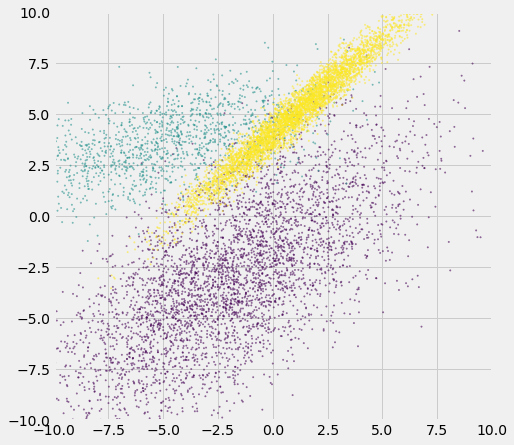

In [5]:
sample = Sample(n=int(1e4), k=3)
sample.plot()

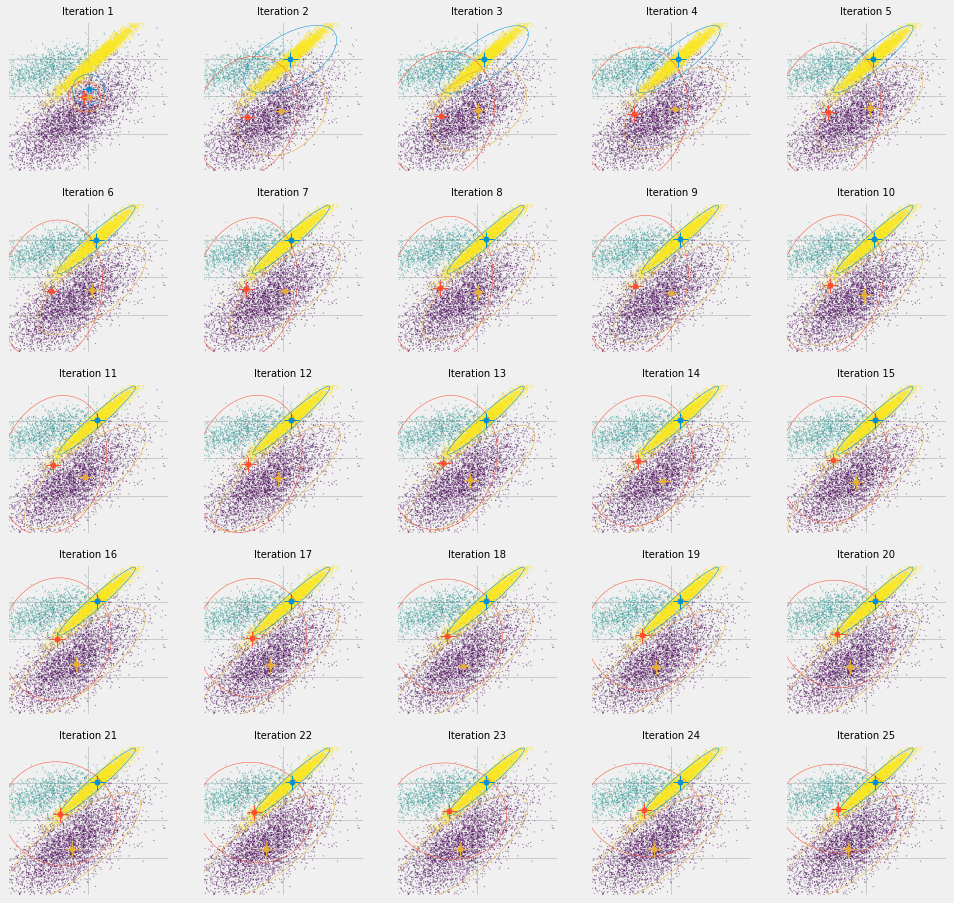

In [6]:
em = EM(sample.x, sample.y, 3)
em.run()